# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
from scipy.stats import moment
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr

import torch
import torch.nn as nn
import torch.nn.functional as F

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

%matplotlib inline

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

## Read index file

In [6]:
path = '/mdi-hmi/to-ml-register-nodiff/train/'
index = pd.read_csv(path + 'index.csv')
index

index                        filename_source  \
0              0    2010/4/7/MDI_20100407-013901_43.npy   
1              1   2010/4/7/MDI_20100407-013901_637.npy   
2              2   2010/4/7/MDI_20100407-013901_638.npy   
3              3   2010/4/7/MDI_20100407-013901_641.npy   
4              4   2010/4/7/MDI_20100407-013901_642.npy   
5              5   2010/4/7/MDI_20100407-013901_643.npy   
6              6   2010/4/7/MDI_20100407-013901_644.npy   
7              7   2010/4/7/MDI_20100407-013901_645.npy   
8              8   2010/4/7/MDI_20100407-013901_646.npy   
9              9   2010/4/7/MDI_20100407-013901_647.npy   
10            10   2010/4/7/MDI_20100407-013901_648.npy   
11            11   2010/4/7/MDI_20100407-013901_649.npy   
12            12   2010/4/7/MDI_20100407-013901_650.npy   
13            13   2010/4/7/MDI_20100407-013901_651.npy   
14            14   2010/4/7/MDI_20100407-013901_652.npy   
15            15   2010/4/7/MDI_20100407-013901_653.npy   
16            16   2010/4/7/MDI_20100407-013901_654.npy   
17            17   2010/4/7/MDI_20100407-013901_655.npy   
18            18   2010/4/7/MDI_20100407-013901_656.npy   
19            19   2010/4/7/MDI_20100407-013901_657.npy   
20            20   2010/4/7/MDI_20100407-013901_636.npy   
21            21   2010/4/7/MDI_20100407-013901_658.npy   
22            22   2010/4/7/MDI_20100407-013901_635.npy   
23            23   2010/4/7/MDI_20100407-013901_633.npy   
24            24   2010/4/7/MDI_20100407-013901_614.npy   
25            25   2010/4/7/MDI_20100407-013901_615.npy   
26            26   2010/4/7/MDI_20100407-013901_616.npy   
27            27   2010/4/7/MDI_20100407-013901_617.npy   
28            28   2010/4/7/MDI_20100407-013901_618.npy   
29            29   2010/4/7/MDI_20100407-013901_619.npy   
...          ...                                    ...   
2282130  2282130  2011/3/31/MDI_20110331-184601_405.npy   
2282131  2282131  2011/3/31/MDI_20110331-184601_406.npy   
2282132  2282132  2011/3/31/MDI_20110331-184601_407.npy   
2282133  2282133  2011/3/31/MDI_20110331-184601_408.npy   
2282134  2282134  2011/3/31/MDI_20110331-184601_389.npy   
2282135  2282135  2011/3/31/MDI_20110331-184601_388.npy   
2282136  2282136  2011/3/31/MDI_20110331-184601_387.npy   
2282137  2282137  2011/3/31/MDI_20110331-184601_386.npy   
2282138  2282138  2011/3/31/MDI_20110331-184601_364.npy   
2282139  2282139  2011/3/31/MDI_20110331-184601_365.npy   
2282140  2282140  2011/3/31/MDI_20110331-184601_366.npy   
2282141  2282141  2011/3/31/MDI_20110331-184601_367.npy   
2282142  2282142  2011/3/31/MDI_20110331-184601_368.npy   
2282143  2282143  2011/3/31/MDI_20110331-184601_369.npy   
2282144  2282144  2011/3/31/MDI_20110331-184601_370.npy   
2282145  2282145  2011/3/31/MDI_20110331-184601_371.npy   
2282146  2282146  2011/3/31/MDI_20110331-184601_372.npy   
2282147  2282147  2011/3/31/MDI_20110331-184601_410.npy   
2282148  2282148  2011/3/31/MDI_20110331-184601_373.npy   
2282149  2282149  2011/3/31/MDI_20110331-184601_375.npy   
2282150  2282150  2011/3/31/MDI_20110331-184601_376.npy   
2282151  2282151  2011/3/31/MDI_20110331-184601_377.npy   
2282152  2282152  2011/3/31/MDI_20110331-184601_378.npy   
2282153  2282153  2011/3/31/MDI_20110331-184601_379.npy   
2282154  2282154  2011/3/31/MDI_20110331-184601_380.npy   
2282155  2282155  2011/3/31/MDI_20110331-184601_381.npy   
2282156  2282156  2011/3/31/MDI_20110331-184601_382.npy   
2282157  2282157  2011/3/31/MDI_20110331-184601_385.npy   
2282158  2282158  2011/3/31/MDI_20110331-184601_374.npy   
2282159  2282159  2011/3/31/MDI_20110331-184601_980.npy   

                               filename_target  patch_num  \
0          2010/4/7/HMI_20100407-013419_43.npy         43   
1         2010/4/7/HMI_20100407-013419_637.npy        637   
2         2010/4/7/HMI_20100407-013419_638.npy        638   
3         2010/4/7/HMI_20100407-013419_641.npy        641   
4         2010/4/7/HMI_20100407-013419_642.npy 

## Define bins for histogram

In [7]:
# Logarithmic bins

dl=0.15  # Logarithmic width
lim = np.log10(5000) # Maximum value
noise_level = 20

# Creating positive part
bins = np.round(np.power(10,np.arange(1,lim+dl,dl)),2)

bins = bins-10+noise_level

# Mirroring it to 0
bins = np.append(np.flip(-(bins)), bins)

# Defining centers and bin widths for the learnable histogram
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

print((bins).astype(int))
print(centers)
print(widths)

[-5021 -3558 -2521 -1788 -1268  -901  -640  -456  -326  -233  -168  -122
   -89   -66   -49   -38   -29   -24   -20    20    24    29    38    49
    66    89   122   168   233   326   456   640   901  1268  1788  2521
  3558  5021]
[-4290.    -3040.01  -2155.085 -1528.605 -1085.09   -771.105  -548.82
  -391.455  -280.05   -201.18   -145.345  -105.815   -77.83    -58.02
   -43.995   -34.065   -27.04    -22.065     0.       22.065    27.04
    34.065    43.995    58.02     77.83    105.815   145.345   201.18
   280.05    391.455   548.82    771.105  1085.09   1528.605  2155.085
  3040.01   4290.   ]
[1463.74 1036.24  733.61  519.35  367.68  260.29  184.28  130.45   92.36
   65.38   46.29   32.77   23.2    16.42   11.63    8.23    5.82    4.13
   40.      4.13    5.82    8.23   11.63   16.42   23.2    32.77   46.29
   65.38   92.36  130.45  184.28  260.29  367.68  519.35  733.61 1036.24
 1463.74]


## Histogram for Batches

In [8]:
class HistLayer(nn.Module):

    def __init__(self,centers,widths):
        super(HistLayer, self).__init__()
        
        # Store centers and widths
        self.centers = centers
        self.widths = widths
        
        # Create array of non-zero centers to ignore noisy part of the spectrum
        nonzero = np.ones(centers.shape[0])
        nonzero[centers==0] = 0
        
        # Center calculation
        self.conv1 = nn.Conv2d(1, centers.shape[0], 1)        
        self.conv1.weight = torch.nn.Parameter(torch.from_numpy(nonzero[:,None,None,None]))
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(-centers*nonzero))
        
        # Width and offset calculation
        self.conv2 = nn.Conv2d(centers.shape[0], centers.shape[0], 1)
        
        # Setting weights and bias to zero for the center bin
        diag = -nonzero/widths
        
        self.conv2.weight = torch.nn.Parameter(torch.from_numpy(np.expand_dims(np.expand_dims(np.diag(diag),axis=2),axis=2)))
        self.conv2.bias = torch.nn.Parameter(torch.from_numpy(nonzero))
        
    def forward(self, x):
        patch_size = x.shape[2]

        if len(x.shape) == 3:
            x = x[:, None, :, :]
        else:
            x = x[:, 0, :, :]
            x = x[:, None]
        
        x = self.conv1(x)
        x = torch.abs(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,patch_size)*patch_size*patch_size
        
        return x

In [9]:
net = HistLayer(centers, widths)
net = net.float()
net

HistLayer(
  (conv1): Conv2d(1, 37, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(37, 37, kernel_size=(1, 1), stride=(1, 1))
)

# Test on Batches

In [10]:
randN = (np.random.rand(10)*index.shape[0]).astype(int)
for idx, val in enumerate(randN):
    if idx==0:
        data = np.load(path + index.loc[val,'filename_target'])
        data = data[None,None,0,:,:]
    else:
        tmp = np.load(path + index.loc[val,'filename_target'])
        tmp = tmp[None,None,0,:,:]
        data = np.append(data,tmp,axis=0)
    
dataP = torch.from_numpy(data)
dataP.shape

torch.Size([10, 1, 128, 128])

In [11]:
cnnhist = net(dataP.float())
cnnhist.shape

torch.Size([10, 37, 1, 1])

## Plot histograms in batch

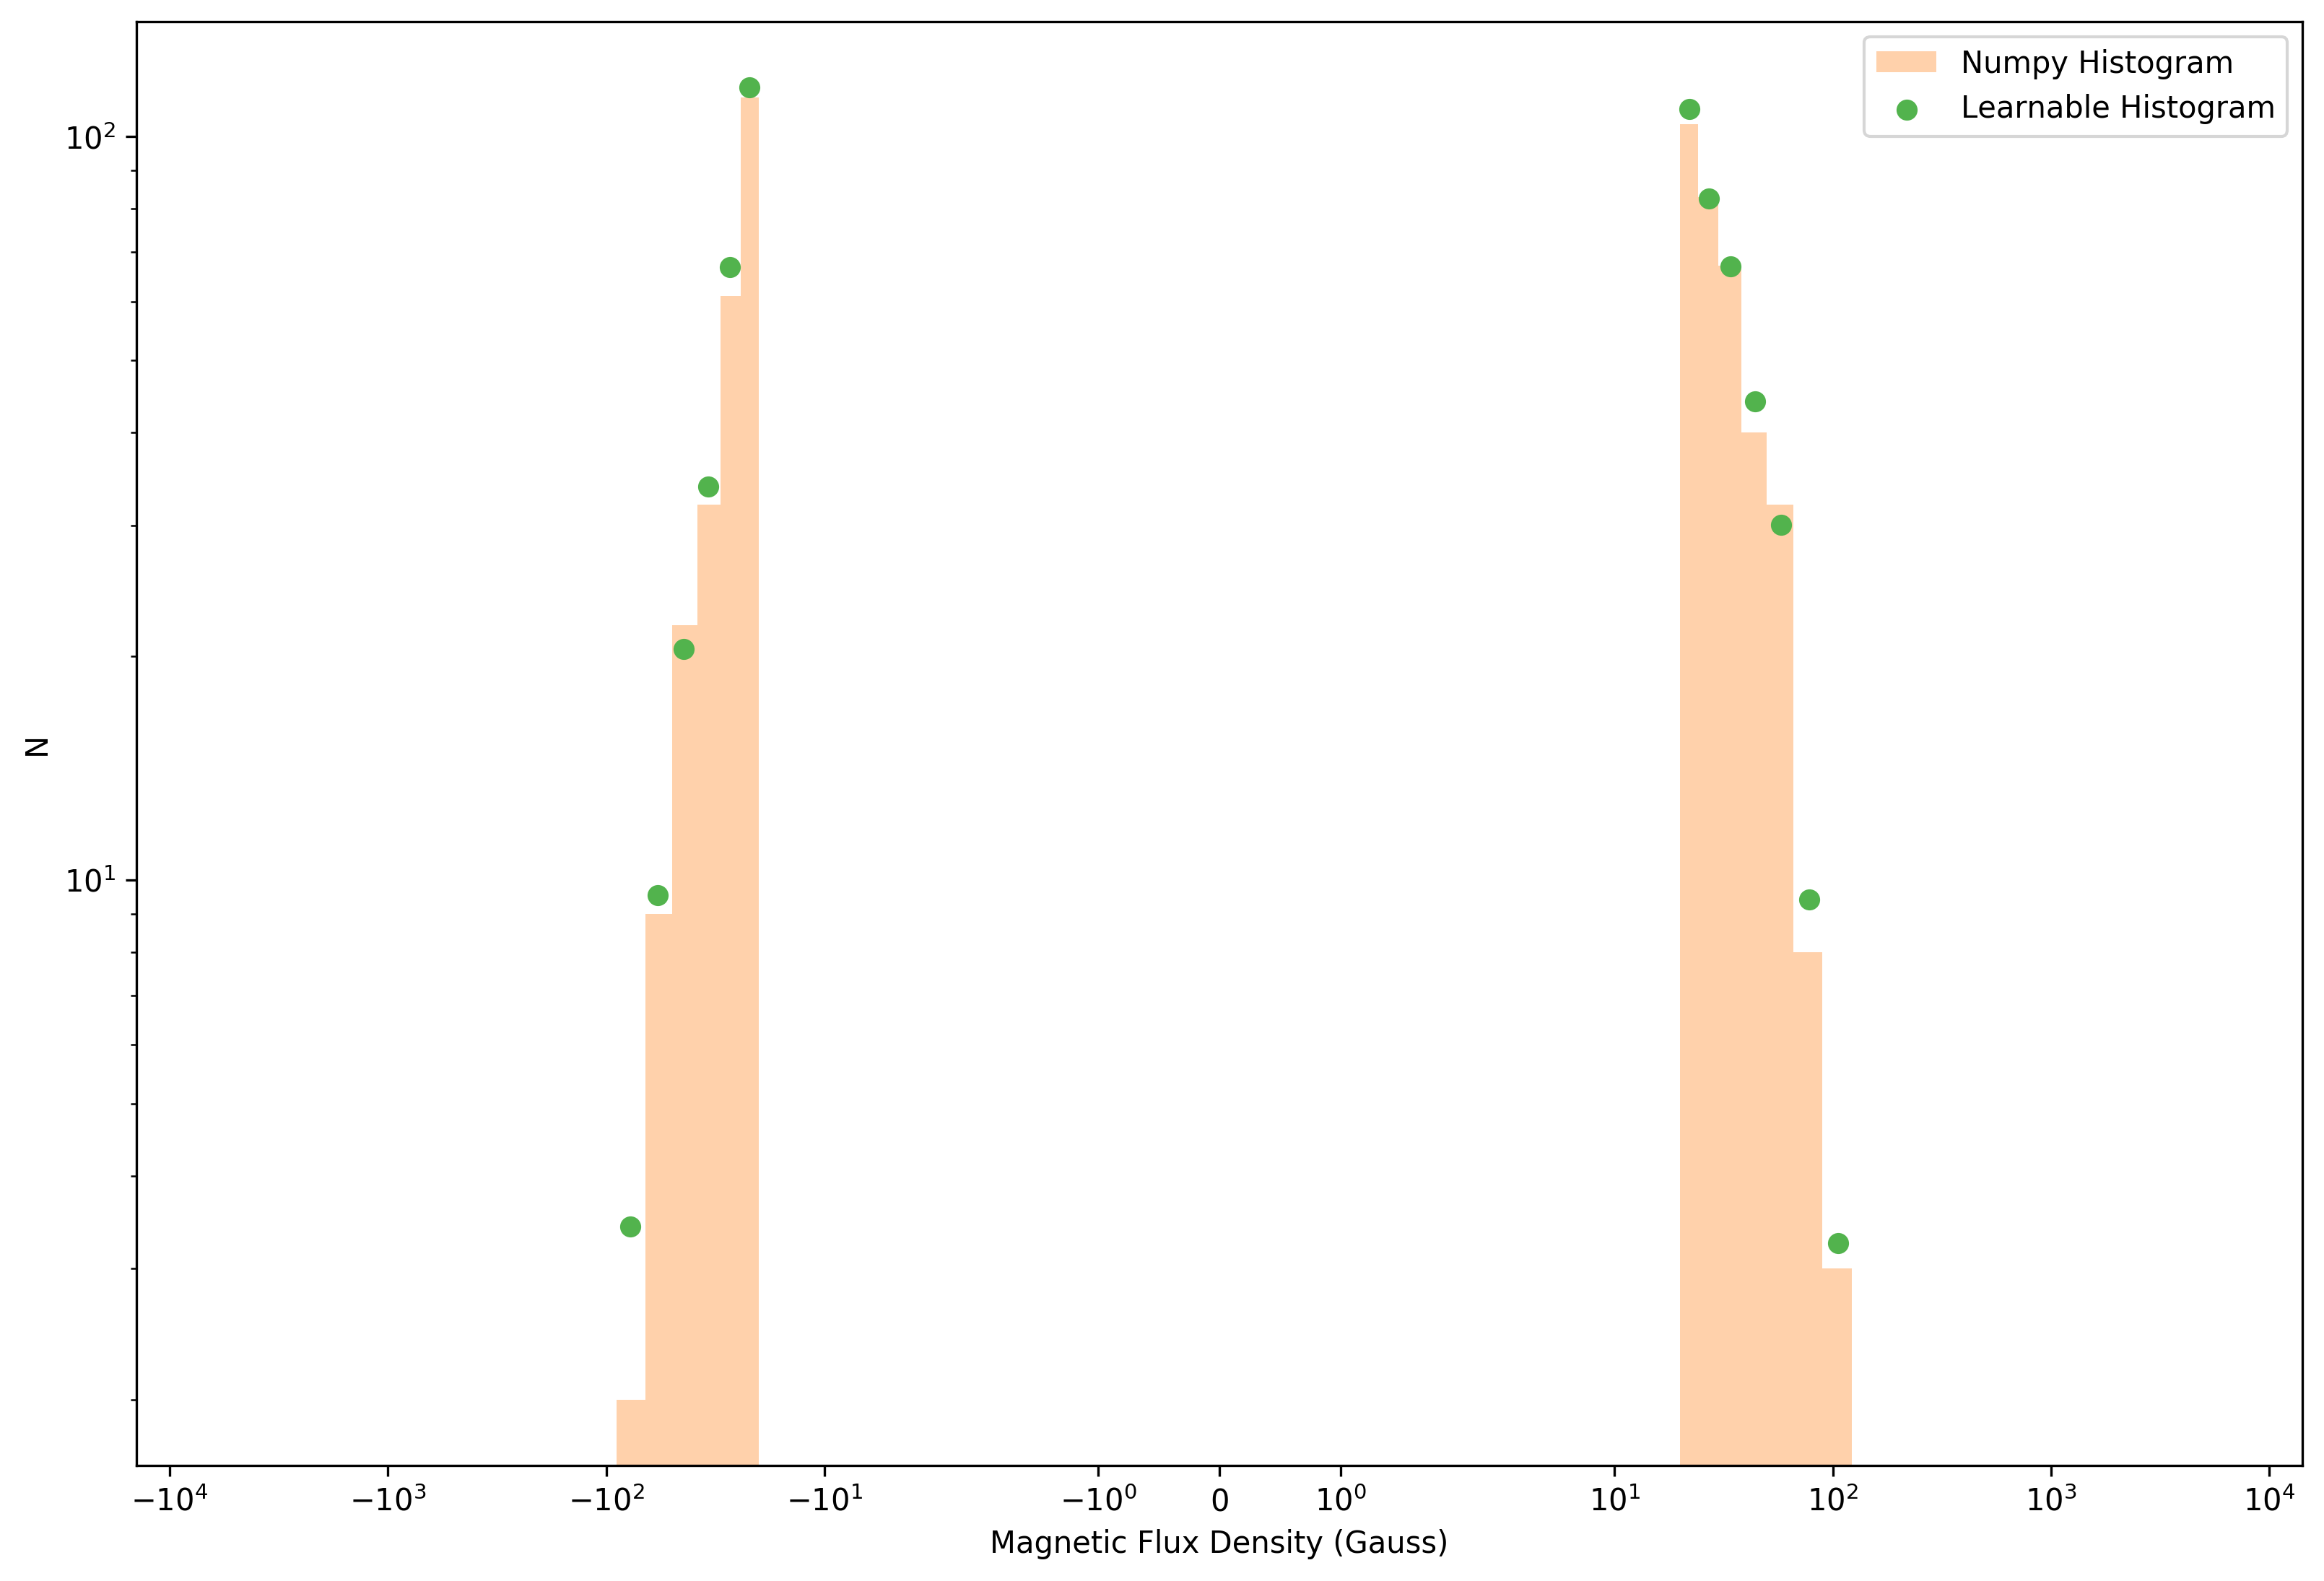

In [12]:
batch_index = 3

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

# Set noise level data to zero
dataN = data[batch_index, 0,:,:].copy()
dataN[np.logical_and(dataN>-noise_level, dataN<noise_level)]=np.nan
ax1.hist(dataN.reshape(-1),bins=bins, label='Numpy Histogram',color=Clr[5])

ax1.scatter(centers,np.squeeze(cnnhist.detach().numpy()[batch_index, :,0,0]), label='Learnable Histogram', color=Clr[3], zorder=2)


ax1.set_yscale('log')
ax1.set_xscale('symlog')

ax1.legend()

ax1.set_xlabel('Magnetic Flux Density (Gauss)')
ax1.set_ylabel('N');
